In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

class DivergenceScore:
    def __init__(self, df):
        """
        df      :   DataFrame with the following columns:
                    - pk: forecast probability bins
                    - ok: number of observations that occurred in each forecast bin (k)
                    - nk: number of observations in total for this forecast bin 
        """        
        self.df = df
        
        # Total number of forecasts, not the sum of the index
        self.N = np.sum(self.df['nk'])
        
        # Set smallest number that can be represented
        self.eps = np.finfo(float).eps

    @classmethod
    def compute_dkl(cls, q, p, eps=1e-10):
        """
        Compute the Kullback-Leibler divergence for given probabilities.
        """
        # Handle case when q or p is 0 or 1 which would result in log2(0)
        q = np.clip(q, eps, 1 - eps)
        p = np.clip(p, eps, 1 - eps)
        dkl = q * np.log2(q / p) + (1 - q) * np.log2((1 - q) / (1 - p))
        return dkl

    @classmethod
    def compute_ds_from_components(cls,rel=None,res=None,unc=None):
        assert rel and res and unc 
        return unc - res + rel 

    def compute_rel(self):
        """
        Compute the reliability component of the Divergence Score.
        """
        total_dkl = 0
        for k in self.df.index:   
            ok_bar = self.df.at[k, 'ok'] / self.df.at[k, 'nk']
            dkl = self.compute_dkl(ok_bar, self.df.at[k, 'pk'], eps=self.eps)
            total_dkl += dkl * self.df.at[k, 'nk']
        return total_dkl / self.N
    
    def compute_res(self):
        """
        Compute the resolution component of the Divergence Score.
        """
        total_dkl = 0
        o_bar = np.sum(self.df['ok']) / self.N
        for k in self.df.index:   
            ok_bar = self.df.at[k, 'ok'] / self.df.at[k, 'nk']
            dkl = self.compute_dkl(ok_bar, o_bar, eps=self.eps)
            total_dkl += dkl * self.df.at[k, 'nk']
        return total_dkl / self.N
    
    def compute_unc(self):
        """
        Compute the uncertainty component of the Divergence Score.
        """
        o_bar = np.sum(self.df['ok']) / self.N
        unc = -((o_bar * np.log2(o_bar)) + ((1 - o_bar) * np.log2(1 - o_bar)))
        return unc

    def compute_ds(self, from_components=False, return_all=False):
        """
        Compute the Divergence Score, either from components or directly.
        """
        if from_components:
            rel = self.compute_rel()
            res = self.compute_res()
            unc = self.compute_unc()
            if return_all:
                print("Note that return_all is ignored outputting components")
            return self.compute_ds_from_components(rel=rel, res=res, unc=unc)
        else:
            # Here you would implement the direct computation of the Divergence Score
            pass


In [3]:
class BrierScore:
    def __init__(self, df):
        """
        df      :   DataFrame with the following columns:
                    - pk: forecast probability bins
                    - ok: number of observations that occurred in each forecast bin (k)
                    - nk: number of observations in total for this forecast bin
        """        
        self.df = df
        
        # Total number of observations
        self.N = np.sum(self.df['nk'])
        
        # Forecast probability bins
        self.ks = self.df.index
        
        # Compute o_bar, the overall average frequency of rain
        self.o_bar = np.sum(self.df['ok']) / self.N
        
    def compute_rel(self):
        """
        Compute the reliability component of the Brier Score.
        """
        rel = np.sum(self.df['nk'] * (self.df['ok'] / self.df['nk'] - self.df['pk']) ** 2) / self.N
        return rel
    
    def compute_res(self):
        """
        Compute the resolution component of the Brier Score.
        """
        res = np.sum(self.df['nk'] * (self.df['ok'] / self.df['nk'] - self.o_bar) ** 2) / self.N
        return res
    
    def compute_unc(self):
        """
        Compute the uncertainty component of the Brier Score.
        """
        unc = self.o_bar * (1 - self.o_bar)
        return unc
    
    def compute_bs(self):
        """
        Compute the Brier Score from its components.
        """
        rel = self.compute_rel()
        res = self.compute_res()
        unc = self.compute_unc()
        bs = rel - res + unc
        return bs


In [4]:
import numpy as np
import pandas as pd

# Define forecast probability bins
pk = np.array([0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 0.995])

# Base rate of the event occurrence
base_rate = 0.005  # 0.5%

# Total forecasts
total_forecasts = 100000

# Initialize random number generator
rng = np.random.default_rng()

# Generate synthetic forecast probabilities uniformly from pk
forecast_probs = rng.choice(pk, size=total_forecasts, p=[1/len(pk)]*len(pk))

# Generate observations with a correlation to the forecast probabilities
observations = rng.random(total_forecasts) < forecast_probs

# Create a DataFrame for the synthetic time series
df_time_series = pd.DataFrame({'forecast_prob': forecast_probs, 'observation': observations.astype(int)})
df_time_series.head(10)


,forecast_prob,observation
0,0.80,1
1,0.60,1
2,0.30,0
3,0.80,1
4,0.10,0
5,0.95,1
6,0.05,0
7,0.05,0
8,0.20,1
9,0.95,1


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Binning data by forecast probability
df_time_series['bin'] = np.digitize(df_time_series['forecast_prob'], bins=pk)

# Initialize arrays to store BS and KL scores
bs_scores = np.zeros(len(pk))
dkl_scores = np.zeros(len(pk))

# Calculate metrics for each bin
for i, p in enumerate(pk, start=1):
    bin_data = df_time_series[df_time_series['bin'] == i]
    if len(bin_data) == 0:  # Skip empty bins
        continue
    # Brier Score for the bin
    bs_scores[i-1] = np.mean((bin_data['forecast_prob'] - bin_data['observation'])**2)
    # Observed frequency
    observed_freq = bin_data['observation'].mean()
    # For KL Divergence approximation: compare the bin's forecast probability to the observed frequency
    if observed_freq > 0 and observed_freq < 1:  # To avoid log(0) issues
        dkl_scores[i-1] = observed_freq * np.log(observed_freq / p) + (1 - observed_freq) * np.log((1 - observed_freq) / (1 - p))
    else:
        dkl_scores[i-1] = 0

# Handle cases where DKL might be undefined due to 0 probabilities
dkl_scores = np.nan_to_num(dkl_scores)


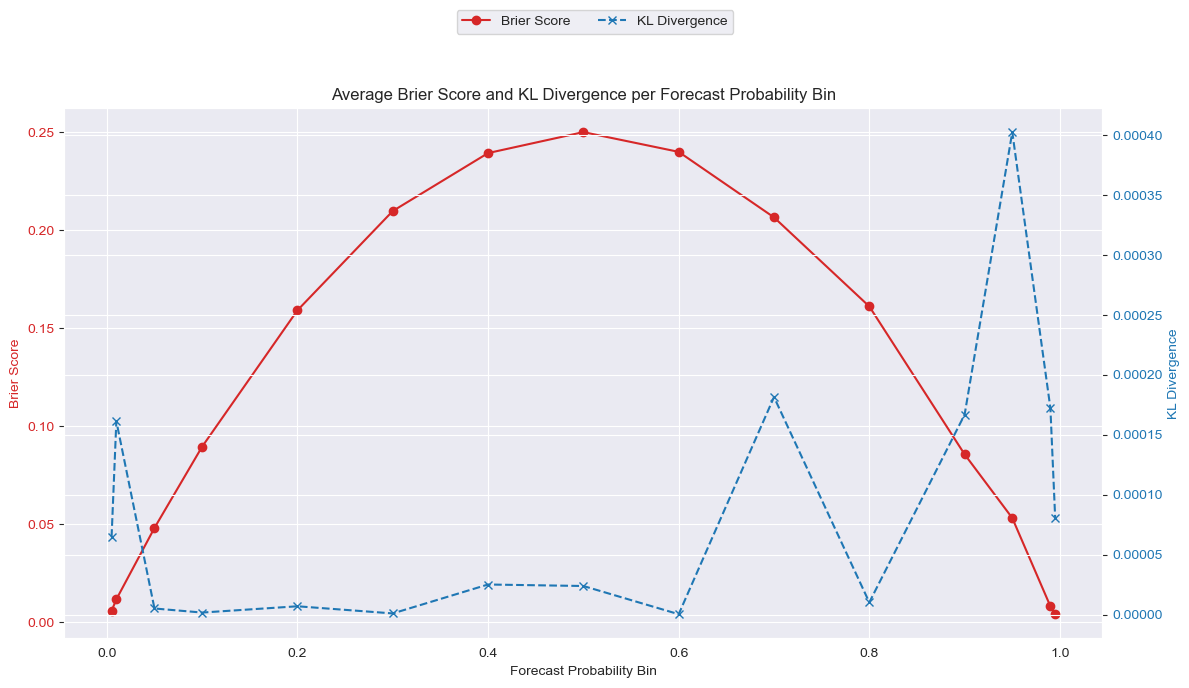

In [23]:
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:red'
ax1.set_xlabel('Forecast Probability Bin')
ax1.set_ylabel('Brier Score', color=color)
ax1.plot(pk, bs_scores, color=color, marker='o', label='Brier Score')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('KL Divergence', color=color)  # we already handled the x-label with ax1
ax2.plot(pk, dkl_scores, color=color, marker='x', linestyle='--', label='KL Divergence')
ax2.tick_params(axis='y', labelcolor=color)

# legend
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Average Brier Score and KL Divergence per Forecast Probability Bin')
plt.show()


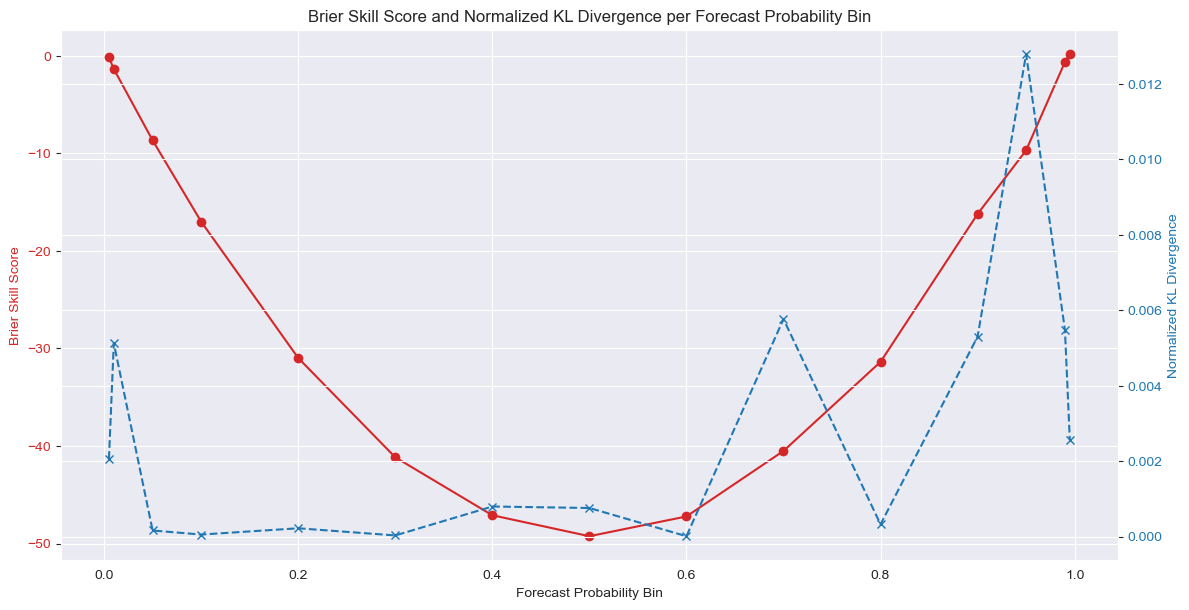

In [24]:
# Prior entropy of the base rate
base_rate_entropy = -base_rate * np.log(base_rate) - (1 - base_rate) * np.log(1 - base_rate)

# Calculate reference Brier Score using the base rate
bs_ref = (base_rate - 1) ** 2 * base_rate + (base_rate ** 2) * (1 - base_rate)

# Initialize arrays to store normalized scores
bss_scores = np.zeros(len(pk))
normalized_dkl_scores = np.zeros(len(pk))

# Calculate normalized scores for each bin
for i, p in enumerate(pk, start=1):
    bin_data = df_time_series[df_time_series['bin'] == i]
    if len(bin_data) == 0:  # Skip empty bins
        continue
    # Brier Skill Score
    bs = np.mean((bin_data['forecast_prob'] - bin_data['observation'])**2)
    bss_scores[i-1] = 1 - bs / bs_ref
    
    # Normalized KL Divergence
    observed_freq = bin_data['observation'].mean()
    if observed_freq > 0 and observed_freq < 1:  # To avoid log(0) issues
        dkl = observed_freq * np.log(observed_freq / p) + (1 - observed_freq) * np.log((1 - observed_freq) / (1 - p))
        normalized_dkl_scores[i-1] = dkl / base_rate_entropy
    else:
        normalized_dkl_scores[i-1] = 0

# Visualization
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:red'
ax1.set_xlabel('Forecast Probability Bin')
ax1.set_ylabel('Brier Skill Score', color=color)
ax1.plot(pk, bss_scores, color=color, marker='o', label='Brier Skill Score')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Normalized KL Divergence', color=color)
ax2.plot(pk, normalized_dkl_scores, color=color, marker='x', linestyle='--', label='Normalized KL Divergence')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # for better layout
plt.title('Brier Skill Score and Normalized KL Divergence per Forecast Probability Bin')
plt.show()


In [7]:
from scipy.stats import entropy

# Brier Score calculation
brier_score = np.mean((df_time_series['forecast_prob'] - df_time_series['observation'])**2)

# Calculate observed frequency
obs_freq = df_time_series['observation'].mean()

# KL Divergence - comparing the forecast distribution to the observed distribution
# Need to bin the data for KL Divergence calculation
prob_bins = np.digitize(df_time_series['forecast_prob'], pk)  # Bin the forecast probabilities
kl_div = entropy([obs_freq, 1-obs_freq], qk=[base_rate, 1-base_rate])

# Print evaluations
print(f"Brier Score: {brier_score}")
print(f"KL Divergence: {kl_div}")


Brier Score: 0.11773882775000004
KL Divergence: 1.9567712008337022


In [8]:
# Bin the dataset
df_binned = df_time_series.groupby(np.digitize(df_time_series['forecast_prob'], pk)).agg(
    ok=('observation', 'sum'),
    nk=('forecast_prob', 'count')
).rename_axis('pk_bin').reset_index()

# Map bin index to pk values
df_binned['pk'] = df_binned['pk_bin'].apply(lambda x: pk[x-1] if x-1 < len(pk) else np.nan)

# Rearrange columns for clarity
df_binned = df_binned[['pk', 'ok', 'nk']]

# Display the binned DataFrame
df_binned


,pk,ok,nk
0,0.005,39,6696
1,0.010,80,6757
2,0.050,342,6746
3,0.100,667,6707
4,0.200,1307,6584
5,0.300,2024,6761
6,0.400,2560,6456
7,0.500,3353,6660
8,0.600,4022,6699
9,0.700,4664,6581


In [9]:
import numpy as np
import pandas as pd

# Forecast probability bins
pk = np.array([0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 0.995])

# Total forecasts
total_forecasts = 100000  # Adjusted for clarity

# Power-law parameter for distribution of n_k
a = 2.5

# Initialize random number generator
rng = np.random.default_rng()

# Generating n_k with a fat-tailed distribution
u = rng.uniform(0, 1, size=len(pk))
n_k = np.ceil((1 - u) ** (-1 / (a - 1)))

# Normalize n_k to match total forecasts while maintaining the fat-tailed distribution
n_k = (n_k / n_k.sum()) * total_forecasts
n_k = np.round(n_k).astype(int)

# Ensure n_k aligns with total forecasts through adjustment
difference = total_forecasts - n_k.sum()
n_k[-1] += difference  # Adjusting the last bin to match the total forecast count

# Generating o_k with distinct randomness for each p_k bin
o_k = np.zeros(len(pk))
for i in range(len(pk)):
    # Adjusting scale for variability while ensuring p remains within [0, 1]
    variability_factor = rng.normal(loc=pk[i], scale=0.1)
    variability_factor = max(min(variability_factor, 1), 0)  # Clamp p to [0, 1]
    
    # Calculating actual_ok with the binomial distribution based on the adjusted p
    actual_ok = rng.binomial(n=n_k[i], p=variability_factor)
    
    # Ensuring o_k is within realistic bounds
    o_k[i] = actual_ok

# Creating DataFrame
df = pd.DataFrame({'pk': pk, 'ok': o_k.astype(int), 'nk': n_k.astype(int)}, index=np.arange(1, len(pk) + 1))
df.index.name = 'k'

# Displaying the resulting DataFrame
df


,pk,ok,nk
k,,,
1,0.005,590,5714
2,0.010,0,5714
3,0.050,623,8571
4,0.100,416,5714
5,0.200,1705,5714
6,0.300,1664,5714
7,0.400,7512,14286
8,0.500,2415,5714
9,0.600,5140,8571


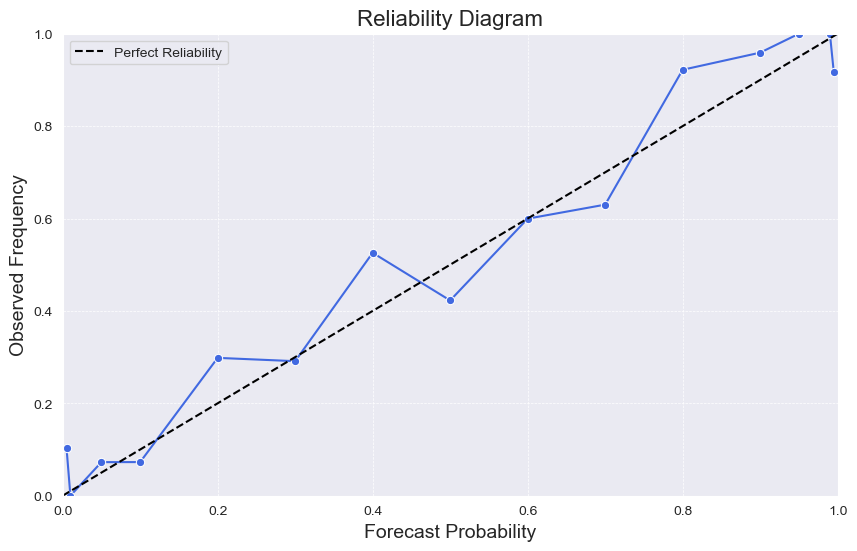

In [10]:
import seaborn as sns

# Calculate observed frequency for the varied ok
observed_frequency_varied = df['ok'] / df['nk']

# Create reliability diagram
plt.figure(figsize=(10, 6))
sns.lineplot(x=df['pk'], y=observed_frequency_varied, marker='o', linestyle='-', color='royalblue')

# Adding perfect reliability line for reference
plt.plot([0, 1], [0, 1], 'k--', label='Perfect Reliability')

# Customizing the plot
plt.title('Reliability Diagram', fontsize=16)
plt.xlabel('Forecast Probability', fontsize=14)
plt.ylabel('Observed Frequency', fontsize=14)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

# Show plot
plt.show()


In [11]:
# Compute the overall base rate of the observations
o_bar = np.sum(df['ok']) / np.sum(df['nk'])
print(f"Overall base rate: {o_bar:.4f}")

Overall base rate: 0.5108


In [12]:
# Let us compute Divergence Score and components for the dataframe df 
ds = DivergenceScore(df)
ds.compute_ds(from_components=True,return_all=True)

Note that return_all is ignored outputting components


0.6332227963896062

In [13]:
# Compute and print the three components of the Divergence Score
rel = ds.compute_rel()
res = ds.compute_res()
unc = ds.compute_unc()
print(f"Reliability: {rel:.4f}")
print(f"Resolution: {res:.4f}")
print(f"Uncertainty: {unc:.4f}")


Reliability: 0.0556
Resolution: 0.4220
Uncertainty: 0.9997


In [14]:
# Now let us compute Brier Score and components for the dataframe df
bs = BrierScore(df)
bs.compute_bs()


0.138481311

In [15]:
# Compute and print the three components of the Brier Score
rel = bs.compute_rel()
res = bs.compute_res()
unc = bs.compute_unc()
print(f"Reliability: {rel:.4f}")
print(f"Resolution: {res:.4f}")
print(f"Uncertainty: {unc:.4f}")


Reliability: 0.0056
Resolution: 0.1170
Uncertainty: 0.2499


In [16]:
# Let's compute the skill score (BSS) for Brier
bss = 1 - (bs.compute_bs() / bs.compute_unc())
print(f"Brier Skill Score: {bss:.4f}")

# Now for Divergence skill score (DSS) 
dss = 1 - (ds.compute_ds(from_components=True) / ds.compute_unc())
print(f"Divergence Skill Score: {dss:.4f}")

Brier Skill Score: 0.4458
Divergence Skill Score: 0.3666


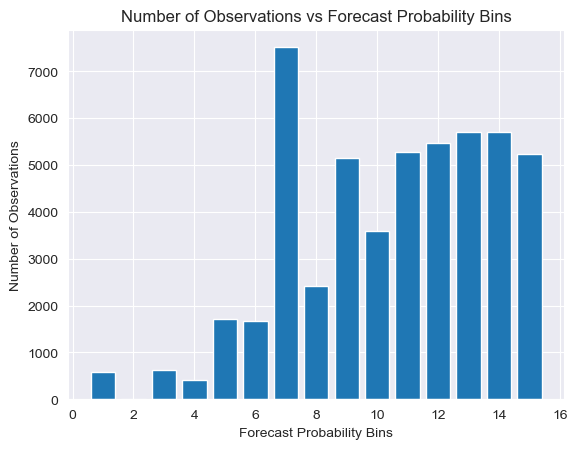

In [17]:
# Let's plot the forecast probability bins against the number of observations that occurred in each forecast bin (k)
plt.bar(df.index, df['ok'])
plt.xlabel('Forecast Probability Bins')
plt.ylabel('Number of Observations')
plt.title('Number of Observations vs Forecast Probability Bins')
plt.show()

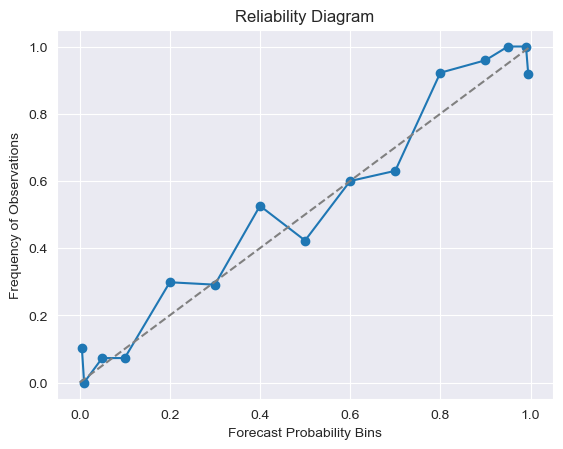

In [18]:
# Plot a reliability diagram, where the x axis is the frequency an observation was observed for that probability forecast bin (y-axis)
plt.plot(df['pk'], df['ok'] / df['nk'], marker='o')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Forecast Probability Bins')
plt.ylabel('Frequency of Observations')
plt.title('Reliability Diagram')
plt.show()

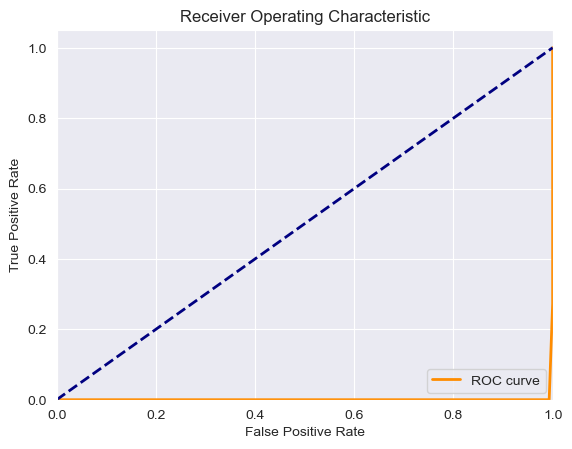

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Assuming df is your dataframe with columns 'pk', 'ok', and 'nk'

# Step 1: Generate the binary outcome array
y_true = np.concatenate([np.repeat(1, ok) for ok in df['ok']] + 
                        [np.repeat(0, nk - ok) for ok, nk in zip(df['ok'], df['nk'])])

# Step 2: Generate the forecast probability array
y_score = np.concatenate([np.repeat(pk, nk) for pk, nk in zip(df['pk'], df['nk'])])

# Step 3: Calculate FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(y_true, y_score)

# Step 4: Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


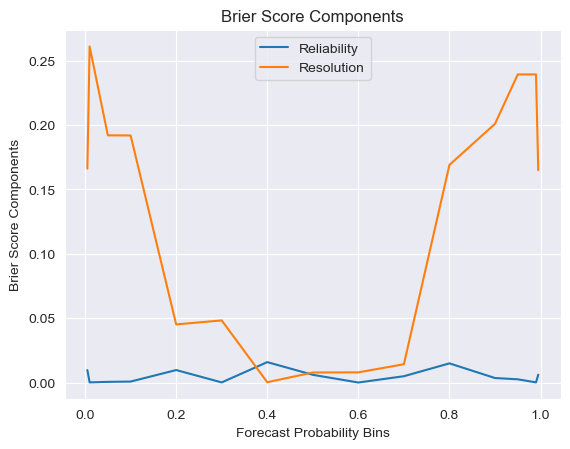

In [20]:
# Plot the RES and REL components of the Brier Score as a function of the forecast probability bins
plt.plot(df['pk'], (df['ok'] / df['nk'] - df['pk']) ** 2, label='Reliability')
plt.plot(df['pk'], (df['ok'] / df['nk'] - np.sum(df['ok']) / np.sum(df['nk'])) ** 2, label='Resolution')
plt.xlabel('Forecast Probability Bins')
plt.ylabel('Brier Score Components')
plt.title('Brier Score Components')
plt.legend()
plt.show()


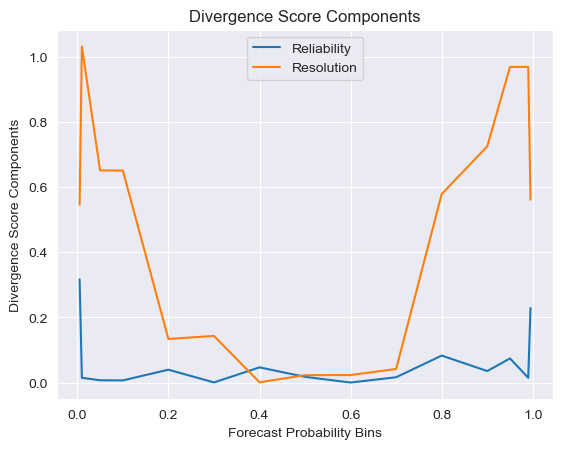

In [21]:
# Plot the RES and REL components of the Divergence Score as a function of the forecast probability bins
plt.plot(df['pk'], ds.compute_dkl(df['ok'] / df['nk'], df['pk']), label='Reliability')
plt.plot(df['pk'], ds.compute_dkl(df['ok'] / df['nk'], np.sum(df['ok']) / np.sum(df['nk'])), label='Resolution')
plt.xlabel('Forecast Probability Bins')
plt.ylabel('Divergence Score Components')
plt.title('Divergence Score Components')
plt.legend()
plt.show()


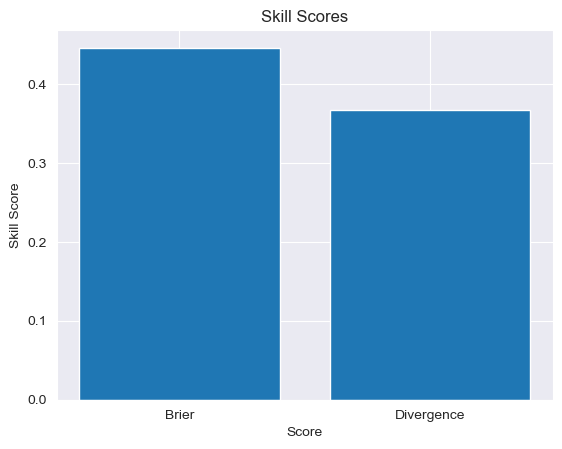

In [22]:
# Plot the Brier skill score and Divergence skill score together 
plt.bar(['Brier', 'Divergence'], [bss, dss])
plt.xlabel('Score')
plt.ylabel('Skill Score')
plt.title('Skill Scores')
plt.show()